# Age Verification 
Using computer vision methods the task is to build and evaluate a model for verifying people's age.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Findings</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Preparing-the-Script" data-toc-modified-id="Preparing-the-Script-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Preparing the Script</a></span><ul class="toc-item"><li><span><a href="#Output" data-toc-modified-id="Output-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Output</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

## Initialization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

Found 7591 validated image filenames.


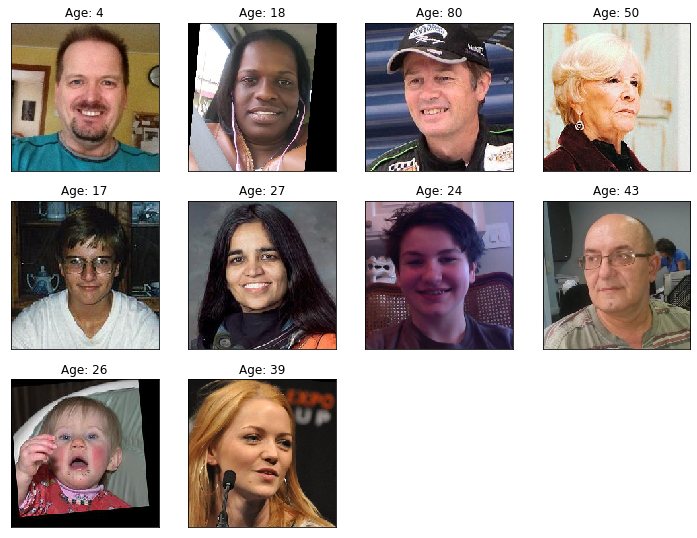

In [19]:
labels=pd.read_csv('/datasets/faces/labels.csv')
display(labels.head())
display(labels.info())
train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(labels['real_age'][i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## EDA

Size of dataset:  (7591, 2)


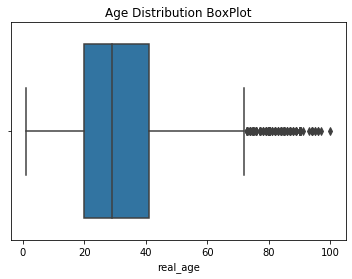

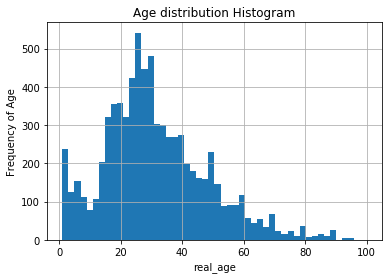

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [23]:
print('Size of dataset: ',labels.shape)
age = labels['real_age']

plt.title('Age Distribution BoxPlot')
sns.boxplot(age)
plt.show()
plt.title('Age distribution Histogram')
age.hist(bins=50)
plt.xlabel('real_age')
plt.ylabel('Frequency of Age')
plt.show()
display(age.describe())

### Findings

The findings from the analysis show that the age is more distributed towards young adults particularly the 21-30 age range by the histogram. The dataset lies mostly between the ages of 20-40 as shown by the boxplot. These findings could affect the model as there is not much data for those below 20 even though they are those that are considered underage. This could result in those under 20 being likely predicted as a being 21-30, leading to more underage alcohol sales. There also seems to be inaccurate ages on some of the photos. Those would need to be removed.

## Modelling

In [20]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(validation_split = 0.25,rescale=1./255,horizontal_flip=True)

def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed=12345)
    features,target=next(train_gen_flow)


    return train_gen_flow

In [21]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'raw',
    subset = 'validation',
    seed=12345)

    return test_gen_flow

In [22]:
def create_model(input_shape=(224,224,3)):
    
    """
    It defines the model
    """
    
    model = Sequential()
    backbone= ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

In [23]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
         validation_steps=validation_steps,
        verbose=2) 

    return model

Train and test results per epoch:

Epoch 1/20

178/178 - 119s - loss: 260.1125 - mae: 11.6788 - val_loss: 687.1383 - val_mae: 21.2579

Epoch 2/20

178/178 - 37s - loss: 100.2533 - mae: 7.6203 - val_loss: 498.2358 - val_mae: 17.2109

Epoch 3/20

178/178 - 37s - loss: 72.6186 - mae: 6.4442 - val_loss: 245.1278 - val_mae: 11.8762

Epoch 4/20

178/178 - 37s - loss: 58.9667 - mae: 5.8524 - val_loss: 137.3975 - val_mae: 8.9843

Epoch 5/20

178/178 - 37s - loss: 50.3765 - mae: 5.3783 - val_loss: 147.3057 - val_mae: 8.8409

Epoch 6/20

178/178 - 37s - loss: 42.7686 - mae: 4.9608 - val_loss: 84.2693 - val_mae: 7.1654

Epoch 7/20

178/178 - 37s - loss: 35.2921 - mae: 4.5625 - val_loss: 75.2594 - val_mae: 6.5165

Epoch 8/20

178/178 - 37s - loss: 30.4379 - mae: 4.1338 - val_loss: 75.4329 - val_mae: 6.4595

Epoch 9/20

178/178 - 37s - loss: 24.8317 - mae: 3.7702 - val_loss: 100.8734 - val_mae: 7.7176

Epoch 10/20

178/178 - 37s - loss: 22.8796 - mae: 3.6255 - val_loss: 71.3954 - val_mae: 6.2994

Epoch 11/20

178/178 - 37s - loss: 18.4236 - mae: 3.2311 - val_loss: 79.4416 - val_mae: 6.7241

Epoch 12/20

178/178 - 37s - loss: 16.9833 - mae: 3.1141 - val_loss: 70.2409 - val_mae: 6.2738

Epoch 13/20

178/178 - 37s - loss: 15.0072 - mae: 2.9511 - val_loss: 73.4277 - val_mae: 6.4349

Epoch 14/20

178/178 - 37s - loss: 14.7152 - mae: 2.9068 - val_loss: 77.5229 - val_mae: 6.7494

Epoch 15/20

178/178 - 37s - loss: 13.4770 - mae: 2.7914 - val_loss: 76.9966 - val_mae: 6.6592

Epoch 16/20

178/178 - 37s - loss: 15.3774 - mae: 2.9460 - val_loss: 77.5959 - val_mae: 6.5555

Epoch 17/20

178/178 - 37s - loss: 12.8292 - mae: 2.6914 - val_loss: 67.1004 - val_mae: 6.1036

Epoch 18/20

178/178 - 37s - loss: 11.5713 - mae: 2.5918 - val_loss: 72.7423 - val_mae: 6.4021

Epoch 19/20

178/178 - 37s - loss: 12.4305 - mae: 2.6549 - val_loss: 67.8989 - val_mae: 6.1445

Epoch 20/20

178/178 - 37s - loss: 11.1901 - mae: 2.5534 - val_loss: 66.0515 - val_mae: 6.0205    

## Preparing the Script

In [24]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Using the Resnet50 model with relu activation, the model has two dense layers of 128 units and one dense layer of 1 unit as only one neuron is needed. A small learning rate of 0.0001 as that provided the best improvement to the MAE score. In training the model, the model was excecuted using 20 epochs. The final result is below:

60/60 - 9s - loss: 68.2247 - mae: 6.1381

Test MAE: 6.1381

The MAE result from these parameters is lower than the task maximum MAE of 8, thus a good result.

## Conclusions

To conclude computer vision could be a good solution to the clients case. The MAE of 6.1 means that there is only a small distinction between actual and predicted ages. For older customers computer vision methods provide a fairly efficient way of determining ability to buy alcohol. However for younger customers between 18-27, an MAE of 6.1 means such methods may not always be accurate, this slightly hinders the usefulness of computer vision as ages 18-27 are near the underage limit.